# LSTM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, CuDNNLSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from time import time

Using TensorFlow backend.


In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
link_train = 'https://drive.google.com/open?id=1wocSG9KQQRB9VvfFceYoWB8gAH0MoFAV'
fluff, id = link_train.split('=')
print (id) # Verify that you have everything after '='

1wocSG9KQQRB9VvfFceYoWB8gAH0MoFAV


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('dataset_05.csv')  

In [5]:
link_test = 'https://drive.google.com/open?id=1bOj5vMjlTnMTEBNImASqwXuHiJ0WB2ab'
fluff, id1 = link_test.split('=')
print (id1) # Verify that you have everything after '='

1bOj5vMjlTnMTEBNImASqwXuHiJ0WB2ab


In [0]:
downloaded1 = drive.CreateFile({'id':id1}) 
downloaded1.GetContentFile('finaltest.csv') 

In [0]:
columns = ['','text_final','polarity','VADER_score','VADER_binary']

train = pd.read_csv('dataset_05.csv',
                     header = 0,
                     names = columns,
                     usecols = [1,2],
                     encoding ='ISO-8859-1')

In [0]:
columns_test = ['','text_no_tag','polarity','length']
test = pd.read_csv('finaltest.csv',
                     usecols = [1,2],
                     header = 0,
                     names = columns_test,
                     encoding ='ISO-8859-1')


In [9]:
len_train = len(train)
print("len training: " , len_train)
len_test = len(test)
print("len test: " , len_test)

len training:  602766
len test:  359


### test polarity 4 ->1

In [0]:
test['polarity'].replace(to_replace=[4],value=1,inplace=True)

In [11]:
train.head()

,text_final,polarity
0,is upset that he can not update his facebook b...,0
1,"@USER no , it ' s not behaving at all . i am m...",0
2,@USER hey long time no see ! yes . rains a bi...,0
3,@USER i could not bear to watch it . and i tho...,0
4,hollis ' death scene will hurt me severely to ...,0


In [12]:
test.head()

,text_no_tag,polarity
0,@USER i love my kindle2 . not that the is co...,1
1,reading my kindle2 . love it . lee childs is...,1
2,"ok , first assesment of the kindle 2 . it fuc...",1
3,@USER you will love your kindle2 . i have had ...,1
4,@USER fair enough . but i have the kindle2 and...,1


In [13]:
train.tail()

,text_final,polarity
602761,woo ! xbox is back,1
602762,"@USER yeah , that does work better than just w...",1
602763,just woke up . having no school is the best fe...,1
602764,happy 3 8 th birthday to my boo of all time !...,1
602765,happy charity tuesday @USER @USER @USER,1


In [14]:
test.tail()

,text_no_tag,polarity
354,"after using latex a lot , any other typeset ma...",1
355,"on that note , i hate word . i hate pages . i ...",0
356,ah . back in a *real* text editing environme...,1
357,"trouble in iran , i see . hmm . iran . iran so...",0
358,reading the tweets coming out of iran . the w...,0


In [15]:
print("n positive tweets:   ", len(train[train['polarity'] == 0]))
print("n negative tweets:   ", len(train[train['polarity'] == 1]))
print("size positive tweets:   ", train[train['polarity'] == 0].size)
print("size negative tweets:   ", train[train['polarity'] == 1].size)

n positive tweets:    253678
n negative tweets:    349088
size positive tweets:    507356
size negative tweets:    698176


### modules explaination

```from keras.preprocessing.text import Tokenizer```

```num_words```: the maximum number of words to keep, based on word frequency. Only the most common num_words words will be kept.

---

- ```fit_on_texts(texts):``` <br>
__Arguments__: <br>
__texts__: list of texts to train on.
    
- ```texts_to_sequences(texts)``` <br>
__Arguments__:<br>
    __texts__: list of texts to turn to sequences.<br>
__Return__: list of sequences (one per text input).

---

```from keras.preprocessing.sequence import pad_sequences```

Pads sequences to the same length.<br>

This function transforms a list of num_samples sequences (lists of integers) into a 2D Numpy array of shape (num_samples, num_timesteps). num_timesteps is either the maxlen argument if provided, or the length of the longest sequence otherwise.<br>

Sequences that are shorter than num_timesteps are padded with value at the end.<br>

Sequences longer than num_timesteps are truncated so that they fit the desired length. The position where padding or truncation happens is determined by the arguments padding and truncating, respectively.<br>

Pre-padding is the default.

```keras.preprocessing.sequence.pad_sequences(sequences, maxlen=None, dtype='int32', padding='pre', truncating='pre', value=0.0)```

__Arguments__

- __sequences__: List of lists, where each element is a sequence.
- __maxlen__: Int, maximum length of all sequences.
- __dtype__: Type of the output sequences. To pad sequences with variable length strings, you can use object.
- __padding__: String, 'pre' or 'post': pad either before or after each sequence.
- __truncating__: String, 'pre' or 'post': remove values from sequences larger than  maxlen, either at the beginning or at the end of the sequences.
- __value__: Float or String, padding value.


In [16]:
%%time
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(train['text_final'].values)

X = tokenizer.texts_to_sequences(train['text_final'].values)
X = pad_sequences(X)
print(X.shape)

(602766, 61)
CPU times: user 33.6 s, sys: 193 ms, total: 33.8 s
Wall time: 33.8 s


In [17]:
print(X.shape[1])

61


### Keras Sequential model

- ```model = Sequential()```<br>
__[READ ME: SEQUENTIAL MODEL EXPLAINATION](https://keras.io/getting-started/sequential-model-guide/)__


- ```keras.layers.Embedding(input_dim, output_dim, embeddings_initializer='uniform', embeddings_regularizer=None, activity_regularizer=None, embeddings_constraint=None, mask_zero=False, input_length=None)``` <br><br>
__Arguments__<br>
    - __input_dim__: int > 0. Size of the vocabulary, i.e. maximum integer index + 1.
    - __output_dim__: int >= 0. Dimension of the dense embedding.
    - __embeddings_initializer__: Initializer for the embeddings matrix (see initializers).
    - __embeddings_regularizer__: Regularizer function applied to the embeddings matrix (see regularizer).
    - __embeddings_constraint__: Constraint function applied to the embeddings matrix (see constraints).
    - __mask_zero__: Whether or not the input value 0 is a special "padding" value that should be masked out. This is useful when using recurrent layers which may take variable length input. If this is True then all subsequent layers in the - model need to support masking or an exception will be raised. If mask_zero is set to True, as a consequence, index 0 cannot be used in the vocabulary (input_dim should equal size of vocabulary + 1).
    - __input_length__: Length of input sequences, when it is constant. This argument is required if you are going to connect  Flatten then Dense layers upstream (without it, the shape of the dense outputs cannot be computed).<br><br>
    
- ```SpatialDropout1D(rate)``` <br>
Spatial 1D version of Dropout. Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting.<br>
This version performs the same function as Dropout, however it drops entire 1D feature maps instead of individual elements. If adjacent frames within feature maps are strongly correlated (as is normally the case in early convolution layers) then regular dropout will not regularize the activations and will otherwise just result in an effective learning rate decrease. In this case, SpatialDropout1D will help promote independence between feature maps and should be used instead.<br><br>

- ```keras.layers.LSTM(units, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, implementation=1, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False)```<br>
Long Short-Term Memory layer - Hochreiter 1997.<br><br>
__Arguments__<br><br>
    - __units__: Positive integer, dimensionality of the output space.
    - __activation__: Activation function to use (see activations). Default: hyperbolic tangent (tanh). If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).
    - __recurrent_activation__: Activation function to use for the recurrent step (see activations). Default: hard sigmoid (hard_sigmoid). If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).
use_bias: Boolean, whether the layer uses a bias vector.
    - __kernel_initializer__: Initializer for the kernel weights matrix, used for the linear transformation of the inputs. (see initializers).
    - __recurrent_initializer__: Initializer for the recurrent_kernel weights matrix, used for the linear transformation of the recurrent state. (see initializers).
    - __bias_initializer__: Initializer for the bias vector (see initializers).
    - __unit_forget_bias__: Boolean. If True, add 1 to the bias of the forget gate at initialization. Setting it to true will also force bias_initializer="zeros". This is recommended in Jozefowicz et al. (2015).
    - __kernel_regularizer__: Regularizer function applied to the kernel weights matrix (see regularizer).
    - __recurrent_regularizer__: Regularizer function applied to the recurrent_kernel weights matrix (see regularizer).
    - __bias_regularizer__: Regularizer function applied to the bias vector (see regularizer).
    - __activity_regularizer__: Regularizer function applied to the output of the layer (its "activation"). (see regularizer).
    - __kernel_constraint__: Constraint function applied to the kernel weights matrix (see constraints).
    - __recurrent_constraint__: Constraint function applied to the recurrent_kernel weights matrix (see constraints).
    - __bias_constraint__: Constraint function applied to the bias vector (see constraints).
    - __dropout__: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs.
    - __recurrent_dropout__: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state.
    - __implementation__: Implementation mode, either 1 or 2. Mode 1 will structure its operations as a larger number of smaller dot products and additions, whereas mode 2 will batch them into fewer, larger operations. These modes will have different performance profiles on different hardware and for different applications.
return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
    - __return_state__: Boolean. Whether to return the last state in addition to the output.
    - __go_backwards__: Boolean (default False). If True, process the input sequence backwards and return the reversed sequence.
    - __stateful__: Boolean (default False). If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch.
    - __unroll__: Boolean (default False). If True, the network will be unrolled, else a symbolic loop will be used. Unrolling can speed-up a RNN, although it tends to be more memory-intensive. Unrolling is only suitable for short sequences.<br><br>
    
- ```keras.layers.Dense(units, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)```<br>
Just your regular densely-connected NN layer.<br>
Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True).<br>
Note: if the input to the layer has a rank greater than 2, then it is flattened prior to the initial dot product with kernel.<br>
__Arguments__

   - __units__: Positive integer, dimensionality of the output space.
   - __activation__: Activation function to use (see activations). If you don't specify anything, no activation is applied (ie. "linear" activation: a(x) = x).
   - __use_bias__: Boolean, whether the layer uses a bias vector.
   - __kernel_initializer__: Initializer for the kernel weights matrix (see initializers).
   - __bias_initializer__: Initializer for the bias vector (see initializers).
   - __kernel_regularizer__: Regularizer function applied to the kernel weights matrix (see regularizer).
   - __bias_regularizer____: Regularizer function applied to the bias vector (see regularizer).
   - __activity_regularizer__: Regularizer function applied to the output of the layer (its "activation"). (see regularizer).
   - __kernel_constraint__: Constraint function applied to the kernel weights matrix (see constraints).
   - __bias_constraint__: Constraint function applied to the bias vector (see constraints).

In [18]:
from keras.layers import Bidirectional

embed_dim = 50
lstm_out = 10

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(CuDNNLSTM(lstm_out)))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 61, 50)            100000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 61, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20)                4960      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 42        
Total params: 105,002
Trainable params: 105,002
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
%%time
Y = pd.get_dummies(train['polarity']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(403853, 61) (403853, 2)
(198913, 61) (198913, 2)
CPU times: user 113 ms, sys: 63.1 ms, total: 176 ms
Wall time: 182 ms


In [20]:
test.head()

,text_no_tag,polarity
0,@USER i love my kindle2 . not that the is co...,1
1,reading my kindle2 . love it . lee childs is...,1
2,"ok , first assesment of the kindle 2 . it fuc...",1
3,@USER you will love your kindle2 . i have had ...,1
4,@USER fair enough . but i have the kindle2 and...,1


```fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None)```<br>
Trains the model for a given number of epochs (iterations on a dataset).

__Arguments__

- __x__: Numpy array of training data (if the model has a single input), or list of Numpy arrays (if the model has multiple inputs). If input layers in the model are named, you can also pass a dictionary mapping input names to Numpy arrays.  x can be None (default) if feeding from framework-native tensors (e.g. TensorFlow data tensors).
- __y__: Numpy array of target (label) data (if the model has a single output), or list of Numpy arrays (if the model has multiple outputs). If output layers in the model are named, you can also pass a dictionary mapping output names to Numpy arrays.  y can be None (default) if feeding from framework-native tensors (e.g. TensorFlow data tensors).
- __batch_size__: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
- __epochs__: Integer. Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided. Note that in conjunction with initial_epoch,  epochs is to be understood as "final epoch". The model is not trained for a number of iterations given by epochs, but merely until the epoch of index epochs is reached.
- __verbose__: Integer. 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
- __callbacks__: List of keras.callbacks.Callback instances. List of callbacks to apply during training. See callbacks.
- __validation_split__: Float between 0 and 1. Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. The validation data is selected from the last samples in the x and y data provided, before shuffling.
- __validation_data__: tuple (x_val, y_val) or tuple  (x_val, y_val, val_sample_weights) on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data.  validation_data will override validation_split.
- __shuffle__: Boolean (whether to shuffle the training data before each epoch) or str (for 'batch'). 'batch' is a special option for dealing with the limitations of HDF5 data; it shuffles in batch-sized chunks. Has no effect when steps_per_epoch is not None.
- __class_weight__: Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.
- __sample_weight__: Optional Numpy array of weights for the training samples, used for weighting the loss function (during training only). You can either pass a flat (1D) Numpy array with the same length as the input samples (1:1 mapping between weights and samples), or in the case of temporal data, you can pass a 2D array with shape  (samples, sequence_length), to apply a different weight to every timestep of every sample. In this case you should make sure to specify sample_weight_mode="temporal" in compile().
- __initial_epoch__: Integer. Epoch at which to start training (useful for resuming a previous training run).
- __steps_per_epoch__: Integer or None. Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined.
- __validation_steps__: Only relevant if steps_per_epoch is specified. Total number of steps (batches of samples) to validate before stopping.


In [21]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

plt.style.use('ggplot')

batch_size = 32
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001, patience=15, verbose=1
)

callbacks_list = [checkpoint, early_stopping]
history = model.fit(X_train, Y_train, validation_split=0.2, epochs=100, batch_size=batch_size, verbose=2, callbacks=callbacks_list)

Train on 323082 samples, validate on 80771 samples
Epoch 1/20
 - 238s - loss: 0.4044 - acc: 0.8166 - val_loss: 0.3773 - val_acc: 0.8305

Epoch 00001: val_loss improved from inf to 0.37729, saving model to model.h5
Epoch 2/20
 - 234s - loss: 0.3757 - acc: 0.8316 - val_loss: 0.3692 - val_acc: 0.8367

Epoch 00002: val_loss improved from 0.37729 to 0.36925, saving model to model.h5
Epoch 3/20
 - 234s - loss: 0.3659 - acc: 0.8371 - val_loss: 0.3691 - val_acc: 0.8391

Epoch 00003: val_loss improved from 0.36925 to 0.36914, saving model to model.h5
Epoch 4/20
 - 234s - loss: 0.3600 - acc: 0.8406 - val_loss: 0.3683 - val_acc: 0.8373

Epoch 00004: val_loss improved from 0.36914 to 0.36827, saving model to model.h5
Epoch 5/20
 - 235s - loss: 0.3564 - acc: 0.8427 - val_loss: 0.3626 - val_acc: 0.8404

Epoch 00005: val_loss improved from 0.36827 to 0.36261, saving model to model.h5
Epoch 6/20
 - 235s - loss: 0.3536 - acc: 0.8437 - val_loss: 0.3639 - val_acc: 0.8416

Epoch 00006: val_loss did not im

In [0]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Training Accuracy: 0.8575
Testing Accuracy:  0.8427


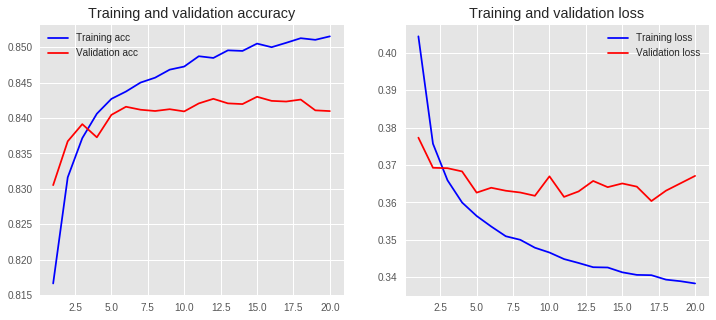

In [23]:
from keras.engine.saving import load_model

model = load_model('model.h5')

loss, accuracy = model.evaluate(X_train, Y_train, verbose=2, batch_size=batch_size)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test, verbose=2, batch_size=batch_size)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [0]:
# print(len(X_validate))
# print(len(Y_validate))
# print(len(X_test))
# print(len(Y_test))

In [25]:
twt = ['@USER i love  my kindle2 . not that the  is cool , but the  is fantastic in its own right .']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=61, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
print(sentiment)
if(np.argmax(sentiment) == 1):
    print("positive")
elif (np.argmax(sentiment) == 0):
    print("negative")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   2   1  23   9  12  19   3  11 155  24
    3  11 581  15  72 519 124]]
[0.06692974 0.9331668 ]
positive


In [26]:
#model = load_model('model_w_embeddings.h5')
sentiment_predicted = []
for tweet in test['text_no_tag']:
    print(tweet)
    tweet = tokenizer.texts_to_sequences([tweet])
    print(tweet)
    #set maxlen as embedding_1 (find it in: embedding_1 (Embedding)      (None, 53, 128)           256000)
    tweet = pad_sequences(tweet, maxlen=61, dtype='int32', value=0)
    print(tweet)
    sentiment = model.predict(tweet, batch_size=1, verbose=2)[0]
    #print(tweet)
    print(sentiment)
    sentiment_predicted.append(np.argmax(sentiment))

print(sentiment_predicted)

@USER i love  my kindle2 . not that the  is cool , but the  is fantastic in its own right .
[[2, 1, 23, 9, 12, 19, 3, 11, 155, 24, 3, 11, 581, 15, 72, 519, 124]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   2   1  23   9  12  19   3  11 155  24
    3  11 581  15  72 519 124]]
[0.06692974 0.9331668 ]
reading my kindle2 .  love it .  lee childs is good read .
[[508, 9, 23, 8, 11, 25, 352]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  508   9  23   8  11  25 352]]
[0.00969706 0.9903138 ]
ok , first assesment of the kindle 2 .  it fucking rocks ! 
[[152, 192, 17, 3, 208, 8, 524, 1328]]
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0

In [27]:
test['polarity_nn'] = sentiment_predicted

test.head()

,text_no_tag,polarity,polarity_nn
0,@USER i love my kindle2 . not that the is co...,1,1
1,reading my kindle2 . love it . lee childs is...,1,1
2,"ok , first assesment of the kindle 2 . it fuc...",1,1
3,@USER you will love your kindle2 . i have had ...,1,1
4,@USER fair enough . but i have the kindle2 and...,1,1


In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [29]:
test.head()

,text_no_tag,polarity,polarity_nn
0,@USER i love my kindle2 . not that the is co...,1,1
1,reading my kindle2 . love it . lee childs is...,1,1
2,"ok , first assesment of the kindle 2 . it fuc...",1,1
3,@USER you will love your kindle2 . i have had ...,1,1
4,@USER fair enough . but i have the kindle2 and...,1,1


In [30]:
print("Accuracy sore: ", accuracy_score(test['polarity'], test['polarity_nn']))
print("Precision score: ", precision_score(test['polarity'], test['polarity_nn'], average='binary'))
print("Recall score: ", recall_score(test['polarity'], test['polarity_nn'], average='binary'))
print("F-measure score: ", f1_score(test['polarity'], test['polarity_nn'], average='binary'))

Accuracy sore:  0.8161559888579387
Precision score:  0.7929292929292929
Recall score:  0.8626373626373627
F-measure score:  0.8263157894736843


In [31]:
test.tail()

,text_no_tag,polarity,polarity_nn
354,"after using latex a lot , any other typeset ma...",1,1
355,"on that note , i hate word . i hate pages . i ...",0,0
356,ah . back in a *real* text editing environme...,1,1
357,"trouble in iran , i see . hmm . iran . iran so...",0,0
358,reading the tweets coming out of iran . the w...,0,0


In [32]:
print("positive polarity: ", len(test[test['polarity']==1]))
print("negative polarity: ", len(test[test['polarity']==0]))
print("positive polarity_nn: ", len(test[test['polarity_nn']==1]))
print("negative polarity_nn: ", len(test[test['polarity_nn']==0]))

positive polarity:  182
negative polarity:  177
positive polarity_nn:  198
negative polarity_nn:  161


In [0]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [0]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(test['polarity'], test['polarity_nn'])
roc_auc = auc(false_positive_rate, true_positive_rate)


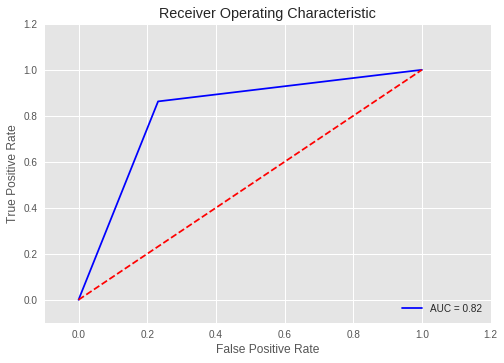

In [35]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()